## `statemodify` Quickstarter Notebook #4: Using External Methods to Generate Synthetic Streamflow Traces

In this notebook, we will demonstrate Option 2 that is provided by `statemodify`, which is the ability to create future states of the world through external methods rather than manipulating the baseline time series as we do in Option 1. Here we offer a method to generate alternative streamflow time series for the five West Slope basins using the `modify_xbm_iwr()` function. 

The Colorado River Basin (CRB) is experiencing a shift to a more arid climate which will likely be characterized by droughts that are longer and more severe than what has been experienced historically. The historic streamflow record is now not a sufficient representation of future hydroclimate. Thus, we need methods of creating plausible future streamflow scenarios for the region that can plausibly expand this historic record.

In this notebook, we demonstrate how to use the multi-site Hidden Markov model (HMM)-based synthetic streamflow generator in `statemodify` to create ensembles of plausible future regional streamflow traces for our five West Slope basins. The HMM is fit to log annual historical streamflow across the outlet gauges of five key basins on the West Slope of the state of Colorado that drain into the Colorado River. The model can then be used to generate streamflow scenarios that envelope the historical record and expand the representation of natural variability in the hydroclimate while still preserving the inter-site correlations across the outlet gauges and at sites within each of the five basins. The HMM-based model is particularly useful for generating sequences of streamflow that exhibit long persistence, including decadal to multidecadal hydrological drought conditions that are scarcely represented within the historical records. 


By fitting the HMM on the historical time series of the basins, we create synthetic traces that are stationary and thus give an indication of the extent of natural variability that characterizes the region. The HMM can be extended to create non-stationary traces, as shown in Hadjimichael et al. (2020), but that version of the model is not currently included in `statemodify`.  

### Step 1: Fit Multi-Site HMM

In [1]:
import argparse
import logging
import os
import pickle
from string import Template
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statemodify as stm

First we define directories and associated paths.

In [2]:
# statemod directory
statemod_dir = "/usr/src/statemodify/statemod_upper_co"

# root directory of statemod data for the target basin
root_dir = os.path.join(statemod_dir, "src", "main", "fortran")

# home directory of notebook instance
home_dir = os.path.dirname(os.getcwd())

# path to the statemod executable
statemod_exe = os.path.join(root_dir, "statemod")

# data directory and root name for the target basin
data_dir = os.path.join(
    home_dir,
    "data",
    "cm2015_StateMod",
    "StateMod"
)

# directory to the target basin input files with root name for the basin
basin_path = os.path.join(data_dir, "cm2015B")

# scenarios output directory
scenarios_dir = os.path.join(data_dir, "scenarios")

# path to iwr/xbm file 
xbm_iwr_template_file = os.path.join(
    home_dir,
    "data",
    "cm2015B_template_xbm_iwr.rsp"
)

We create a function `hmm_multisite_fit()` that houses the Python code to fit the multi-site HMM to annual flow at the outlet gauges of the five basins. In this function, you can specify the output directory to store the HMM parameters. 

In [3]:
#Make directory to store HMM parameters

output_dir = os.path.join(data_dir, "HMM_parameters")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

n_basins = 5

# choice to save parameters to NumPy array files
save_parameters = True

fit_array_dict = stm.hmm_multisite_fit(n_basins=n_basins,
                                       save_parameters=save_parameters,
                                       output_directory=output_dir)

# unpack output dictionary
unconditional_dry = fit_array_dict["unconditional_dry"]
unconditional_wet = fit_array_dict["unconditional_wet"]
logAnnualQ_h = fit_array_dict["logAnnualQ_h"]
transition_matrix = fit_array_dict["transition_matrix"]
covariance_matrix_wet = fit_array_dict["covariance_matrix_wet"]
covariance_matrix_dry = fit_array_dict["covariance_matrix_dry"]
wet_state_means = fit_array_dict["wet_state_means"]
dry_state_means = fit_array_dict["dry_state_means"]


### Step 2: Sample from multi-site HMM

We then use the `hmm_multisite_sample()` function to sample from the HMM 100 times to develop 100 alternative, 105-year traces of streamflow at the outlet gauge of each basin and we save each trace in a .csv file in the `HMM_Runs` folder.

In [4]:
#Create a folder to store the runs

output_dir = os.path.join(data_dir, "HMM_Runs")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# using the outputs of the fit function above; this function write output sample files to the output directory
stm.hmm_multisite_sample(logAnnualQ_h,
                         transition_matrix,
                         unconditional_dry,
                         dry_state_means,
                         wet_state_means,
                         covariance_matrix_dry,
                         covariance_matrix_wet,
                         n_basins=n_basins,
                         output_directory=output_dir)

Then one can plot flow duration curves (FDCs) of the annual synthetically generated flow at each basin compared to the the historical record. We see that the HMM is enveloping the historical record and also expanding it around it, particularly around the tails of the distribution, which will lead to more instances of extreme flood and drought events.   

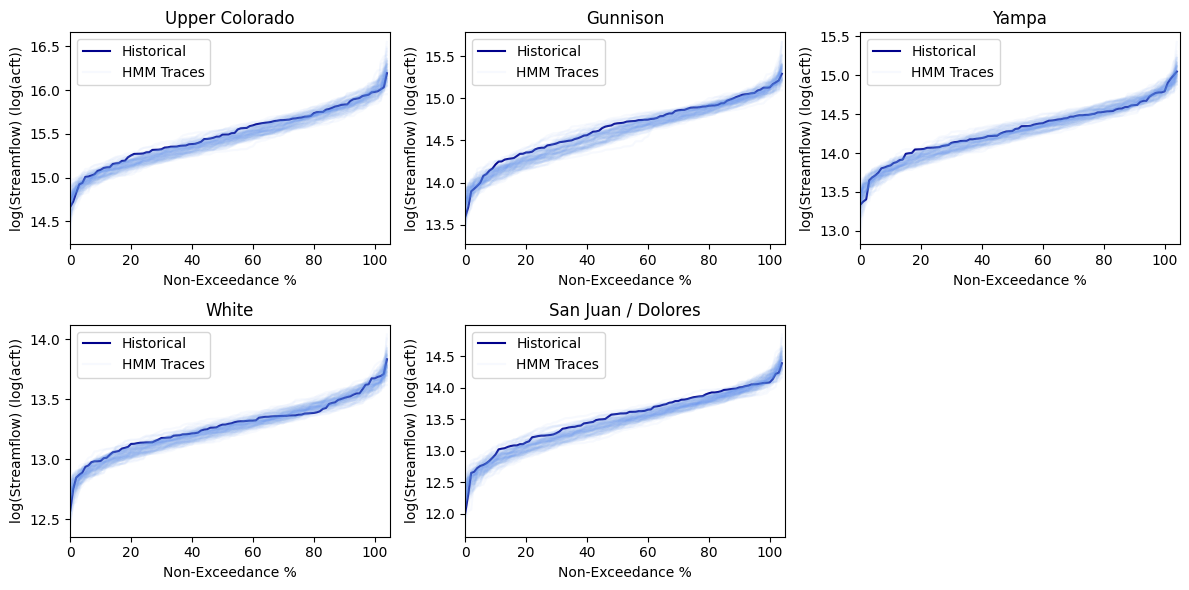

In [5]:
stm.plot_flow_duration_curves(flow_realizations_directory=output_dir,
                              save_figure=True,output_directory=output_dir,
                              figure_name= 'FDC',
                              dpi= 300)

### Step 3: Modify StateMod Input Files for Exploratory Analyses- Streamflow Example

In order for the HMM to be used in conjunction with StateMod, we utilize a statistical disaggregation technique to disaggregate the synthetically generated outlet gauge flow to the upstream nodes and also from an annual to monthly time scale. The synthetic log-space annual flows are converted to real space and temporally downscaled to monthly flows using a modification of the proportional scaling method used by Nowak et al. (2010). First, a historical year is probabilistically selected based on its “nearness” to the synthetic flow at the last node in terms of annual total. The shifted monthly flows at the last node are then downscaled to all other nodes using the same ratios of monthly flows at the upstream nodes to the last node as in the historically selected year.Though not demonstrated in this notebook, the irrigation demands (in the `.iwr` file) are also inherently tied to the generation of the streamflow, as irrigation demands will increase in dry years. Thus, a regression is fit across historical irrigation anomalies and historical annual flow anomalies and the appropriate irrigation anomaly is determined from this regression for every synthetically generated flow anomaly. More information on this method can be found in Hadjimichael et al., 2020. All of this functionality is embedded in the `modify_xbm_iwr()` function.  

In [6]:
#Make directory to store input files 

output_dir = os.path.join(data_dir, "input_files")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    

flow_realizations_directory = os.path.join(data_dir, "HMM_Runs")
    
scenario = "1"

# basin name to process
basin_name = "Upper_Colorado"

# seed value for reproducibility if so desired
seed_value = 123

# number of jobs to launch in parallel; -1 is all but 1 processor used
n_jobs = 2

# number of samples to generate (how many new xbm and iwr files); produces an IWR multiplier
n_samples = 1

# generate a batch of files using generated LHS
stm.modify_xbm_iwr(output_dir=output_dir,
                   flow_realizations_directory=flow_realizations_directory,
                   scenario=scenario,
                   basin_name=basin_name,
                   seed_value=seed_value,
                   n_jobs=n_jobs,
                   n_samples=n_samples,
                   save_sample=True,
                   randomly_select_flow_sample=True)    

### Step 4: Read in the New Input Files and Run StateMod : Streamflow Example

Now that we have created the new files, the next step is to run them through StateMod. We create a template `.rsp` file (`cm2015B_template_xbm_iwr.rsp`) and swap in the path to the alternative `.xbm` and `.iwr` files that are created. Then we run StateMod for the single scenario and one can then go on and extract shortages or reservoir levels.

<div class="alert alert-block alert-info"> <b>NOTE</b> In order to expedite simulations for the Upper Colorado dataset, make sure to turn off "Reoperation" mode. You can do so by opening /home/jovyan/data/cm2015_StateMod/StateMod/cm2015.ctl, navigating to the "ireopx" entry and changing the value from "0" to "10".  </div>


In [7]:
# set realization and sample
realization = 1
sample = np.arange(0, 1, 1)

# read RSP template
with open(xbm_iwr_template_file) as template_obj:
    
    # read in file
    template_rsp = Template(template_obj.read())

    for i in sample:
        
        # create scenario name
        scenario = f"S{i}_{realization}"
        
        # dictionary holding search keys and replacement values to update the template file
        d = {"XBM": f"../../input_files/cm2015B_{scenario}.xbm","IWR": f"../../input_files/cm2015B_{scenario}.iwr"}
        
        # update the template
        new_rsp = template_rsp.safe_substitute(d)
        
        # construct simulated scenario directory
        simulated_scenario_dir = os.path.join(scenarios_dir, scenario)
        if not os.path.exists(simulated_scenario_dir):
            os.makedirs(simulated_scenario_dir)
            
        # target rsp file
        rsp_file = os.path.join(simulated_scenario_dir, f"cm2015B_{scenario}.rsp")
        
        # write updated rsp file
        with open(rsp_file, "w") as f1:
            f1.write(new_rsp)
        
        # construct simulated basin path
        simulated_basin_path = f"cm2015B_{scenario}"

        # run StateMod
        print(f"Running: {scenario}")
        os.chdir(simulated_scenario_dir)

        subprocess.call([statemod_exe, simulated_basin_path, "-simulate"])


Running: S0_1
  Parse; Command line argument: 
  cm2015B_S0_1 -simulate                                                                                                         
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version: 15.00.01
        Last revision date: 2015/10/28

________________________________________________________________________

  Opening log file cm2015B_S0_1.log                                                                                                                                                                                                                                                
  
  Subroutine Execut
  Subroutine Datinp

________________________________________________________________________
  Datinp; Control File (*.ctl) 

________________________________________________________________________
  Datinp

It's easiest to see the value of generating multiple streamflow scenarios if we run 100-1000 scenarios through StateMod. However, this container does not have the resources to support exploratory modeling at this scale. So we run these simulations externally and below, we read in the `.xre` files with the `read_xre()` helper function and show the distribution of the reservoir levels that are observed across Lake Granby in the Upper Colorado under the 100 simulated scenarios versus the historical 105-year period.

Archive:  /home/8f04c5969ed54204a64388872dd1b557/data/Granby_Dataset.zip
   creating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/cm2015B.xre  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data_hist.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data_S0_1.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data_S10_1.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data_S11_1.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data_S12_1.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Granby_xre_data_S13_1.csv  
  inflating: /home/8f04c5969ed54204a64388872dd1b557/data/Upper_Colorado/Gran

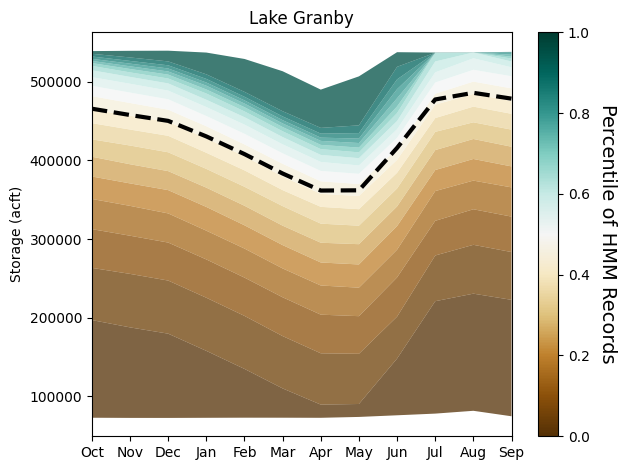

In [10]:
# Example with Granby Lake
zip_file_path = os.path.join(home_dir, 'data', 'Granby_Dataset.zip')
final_directory = os.path.join(home_dir, 'data/')

!unzip $zip_file_path -d $final_directory  
granby_hmm, granby_hist, granby_hist_mean, granby_hist_1p = stm.read_xre(os.path.join(home_dir,"data/Upper_Colorado/"), 'Granby')

# Plot quantiles
stm.plot_res_quantiles(granby_hmm, granby_hist_mean, 'Lake Granby')

Here, we plot the monthly reservoir storage quantiles across each month of the year. The shading corresponds to the larger 100-member sample from the HMM and the dotted black line corresponds to the monthly average storage across the historical 105-year record. Importantly, the HMM is expanding the distribution of reservoir storages, particularly creating both larger and smaller storages, meaning that we are capturing reservoir levels under a broader range of wetter and drier conditions that could have implications for shortages for users.

We can also plot the range of monthly storages from the HMM and historical period as box plots for an alternative comparison using the `plot_reservoir_boxes()` helper function.

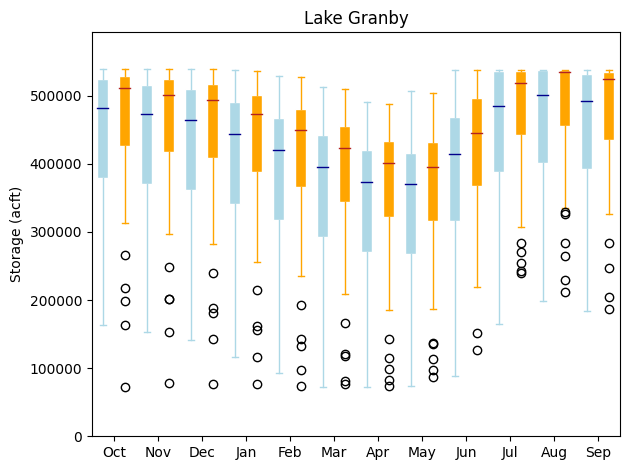

In [11]:
# using the output of the above `read_xre` function as inputs
stm.plot_reservoir_boxes(granby_hmm, granby_hist, 'Lake Granby')

Here, the blue box plots correspond to the HMM-generated reservoir storages and the orange box plots correspond to the historical monthly dataset. The black circles represent outliers. As illustrated in the quantile plot above as well, for all months, the HMM is creating a wider distribution of reservoir storages, and tends to be able to encompass even historical outliers. Remember that the HMM has only been fit on the historical dataset. Thus, the HMM can provide an estimate of the expanse of reservoir storages that can be expected just within the range of natural variability, which is quite large! Particularly, the HMM is creating many more instances of drier scenarios and lower reservoir levels which can be very useful for informing drought vulnerability assessments. 

### References

Nowak, K., Prairie, J., Rajagopalan, B., & Lall, U. (2010). A nonparametric stochastic approach for multisite disaggregation of annual to daily streamflow. Water resources research, 46(8).